# Test Grid Coherence


Comparing grid simulation + coherence time test result to OG Gaussian clouds

LJK

Date created: 07/16/25

Last edited: 08/11/25

In [1]:
import math
import numpy as np
import pandas as pd
import xarray as xr
from numba import njit
import matplotlib.pyplot as plt
from scipy.stats import linregress

from config import *

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

Get metadata

In [5]:
metadata_df = pd.read_csv(data_dir  + 'AVISO_eddies/AVISO_metadata_15km_near_eddy.csv',index_col=0)
metadata_df = metadata_df[12:] # sample 16 & later

In [6]:
coh_df = pd.read_csv(data_dir + 'parcels_trajs/gaussian_seeding_sample_sites/CMEMS_coherence_time_by_run.csv',index_col=0)/4 # divide by 4 to convert from 6-hourly to daily
coh_df.head()

,cmems_run0,cmems_run1,cmems_run2,cmems_run3
sample_id,,,,
16,33.00,33.00,32.00,32.75
17,44.00,43.50,43.50,43.50
18,40.50,39.75,40.25,40.00
19,97.50,96.75,97.00,97.00
20,63.75,63.75,62.75,64.50


In [7]:
metadata_df['CMEMS_avg_coh'] = list(np.mean((coh_df.cmems_run0,coh_df.cmems_run1,coh_df.cmems_run2),axis=0))
metadata_df.head()

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,CMEMS_avg_coh
14,16,20211120,10:54,29.0000,236.5574,0,0,0,0,32.666667
15,17,20211120,12:44,28.7390,236.1088,0,0,0,0,43.666667
16,18,20211120,14:43,28.5030,235.7140,0,0,0,0,40.166667
17,19,20211121,02:03,28.2847,235.3517,0,0,0,0,97.083333
18,20,20211121,04:04,28.0397,234.9534,0,0,0,0,63.416667


In [8]:
outside_eddy_df = metadata_df[~((metadata_df['in_anti']!=0) | (metadata_df['near_anti']!=0)
                               | (metadata_df['in_cyc']!=0) | (metadata_df['near_cyc']!=0))]
outside_eddy_df

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,CMEMS_avg_coh
14,16,20211120,10:54,29.0000,236.5574,0,0,0,0,32.666667
15,17,20211120,12:44,28.7390,236.1088,0,0,0,0,43.666667
16,18,20211120,14:43,28.5030,235.7140,0,0,0,0,40.166667
17,19,20211121,02:03,28.2847,235.3517,0,0,0,0,97.083333
18,20,20211121,04:04,28.0397,234.9534,0,0,0,0,63.416667
21,23,20211121,09:53,27.3373,233.7767,0,0,0,0,45.583333
22,24,20211121,11:53,27.0992,233.3740,0,0,0,0,12.833333
26,28,20211122,00:41,26.1498,231.8127,0,0,0,0,61.166667
27,29,20211122,02:10,25.9711,231.5141,0,0,0,0,39.916667
28,30,20211122,04:03,25.7446,231.1433,0,0,0,0,119.583333


Set up indexing from Lagrangian trajectories

In [9]:
# Open trajectory dataset (computed with `run_parcels_CMEMS_NPSG_outside_eddies.py`)
traj_ds = xr.open_dataset(data_dir + 'parcels_trajs/2021-11-23_200days_runtime_20min_timestep_0.02_spatial_res_24hr_output_freq_outside_15km_eddy_buff_NPSG_domain.nc')

# Read in lats and lons to help increase speed later when these are indexed frequently
traj_lats = traj_ds.lat.values
traj_lons = traj_ds.lon.values

In [10]:
# Assign indices to each particle based on what would be a regular initialization grid
init_lons, init_lats = np.unique(traj_lons[:,0]),np.unique(traj_lats[:,0])
lat_to_i = {lat: i for i, lat in enumerate(init_lats)}
lon_to_j = {lon: j for j, lon in enumerate(init_lons)}

# Map the actual coordinates to the gridded indeces
lat_index = np.array([lat_to_i[lat] for lat in traj_lats[:,0]])
lon_index = np.array([lon_to_j[lon] for lon in traj_lons[:,0]])

# Add the lat/lon indeces to a pandas dataframe, assigned to each traj
lookup_df = pd.DataFrame({'particle': np.arange(traj_ds.traj.size),
                    'lat_index': lat_index,
                    'lon_index': lon_index})

# MultiIndex for quick lookup (more than one variable can be set to index)
lookup_df.set_index(['lat_index', 'lon_index'], inplace=True) 

45


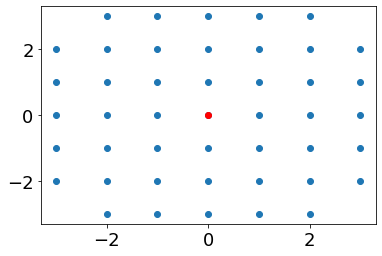

In [28]:
# Neighbor indeces; circle of points around center with 0.1 degree diameter 
offsets = []

# V3: ~8.3 km radius for 0.02 resolution
for y in range(-2,3):
    offsets.extend([(x,y) for x in range(-3,4)])
offsets.extend([(x,-3) for x in range(-2,3)])
offsets.extend([(x,3) for x in range(-2,3)])
print(len(offsets))

plot = plt.scatter([o[0] for o in offsets],[o[1] for o in offsets])
plt.scatter(0,0,c='r')

In [29]:
# Calculate a weight based on the Euclidean distances for each point
weights = []
for point in offsets: 
    weights.append((4-np.linalg.norm(np.array(point)-np.array([0,0]))))
print(min(weights))
print(max(weights))

0.3944487245360109
4.0


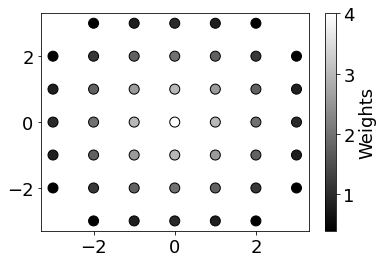

In [30]:
plot = plt.scatter([o[0] for o in offsets],[o[1] for o in offsets],c=weights,edgecolor='k',cmap='gray',s=100)

plt.colorbar(plot,label='Weights')

In [31]:
m = 16
cloud_ds = xr.open_dataset(data_dir + 'parcels_trajs/gaussian_seeding_sample_sites/CMEMS_runs/samplesite%s_200day_backward_runtime_20min_timestep_6hr_output_freq_1000_gaussian_particles_0.025_std_dist_cmems_run1.nc'%(m))
cloud_ds

<xarray.Dataset>
Dimensions:     (obs: 801, traj: 1000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

In [32]:
def find_nearest(array, value):
    """
    Find nearest item in the array to the input value
    
    Input
        array: array to find the value in
        value: value of interest
    Output:
        idx: index of the value in the array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

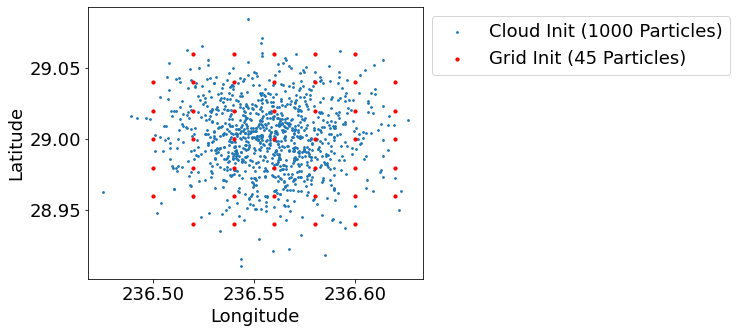

In [33]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.scatter(cloud_ds.lon[:,0],cloud_ds.lat[:,0],s=3,label='Cloud Init (1000 Particles)')

sample_lon,sample_lat = np.array(outside_eddy_df.longitude),np.array(outside_eddy_df.latitude)
lon,lat = sample_lon[0],sample_lat[0]
lon_i,lat_i = find_nearest(init_lons, lon),find_nearest(init_lats, lat) # target inds
center = (lat_i, lon_i) # center point of the cloud
neighbors = [(center[0] + di, center[1] + dj) for di, dj in offsets] # all of the cloud neighbors
neighbor_ds_locs = np.array([lookup_df.loc[nbr][0] for nbr in neighbors])

ax.scatter([traj_lons[n,0] for n in neighbor_ds_locs],
           [traj_lats[n,0] for n in neighbor_ds_locs],s=10,c='r',label='Grid Init (%s Particles)'%(len(offsets)))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.legend(bbox_to_anchor=(1,1))

Functions for coherence calculation

In [34]:
@njit
def distance_from_lat_lon(lat1,lon1,lat2,lon2):
    """
    Returns the Haversine distance between two geographic coordinate points. Accepts negative (-180 to 180) or positive coordinate systems (0 to 360). 
    
    Using numpy instead of math package for numba efficiency

    Input
        lat1,lon1: geographic coordinates for point 1
        lat2,lon2: geographic coordinates for point 2
    Output
        dist: distance between the two point (units of kilometers)
    """
    R = 6371 # Radius of the earth in km
    delta_lat,delta_lon = np.radians(lat2-lat1),np.radians(lon2-lon1)
    lat1_radians,lat2_radians = np.radians(lat1),np.radians(lat2)
    a = np.sin(delta_lat/2) * np.sin(delta_lat/2) + np.cos(lat1_radians) * np.cos(lat2_radians) * ((np.sin(delta_lon/2))**2)
    dist = R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) # Distance in km
    return dist

Iterate through outside eddy samples to get grid coherence

In [21]:
def weighted_mean(values, weights):
    weighted_sum = sum(v * w for v, w in zip(values, weights))
    total_weight = sum(weights)    
    return weighted_sum / total_weight

In [22]:
gridded_coh = [np.nan]*len(sample_lon)

for s in np.arange(0,len(sample_lon)):
    lon,lat = sample_lon[s],sample_lat[s]
    lon_i,lat_i = find_nearest(init_lons, lon),find_nearest(init_lats, lat) # target inds
    center = (lat_i, lon_i) # center point of the cloud
    neighbors = [(center[0] + di, center[1] + dj) for di, dj in offsets] # all of the cloud neighbors
    
    try:
        neighbor_ds_locs = np.array([lookup_df.loc[nbr][0] for nbr in neighbors])
    except:
        continue
        

    center_traj = int(lookup_df.loc[center][0])
    max_dist_t0 = np.max([distance_from_lat_lon(traj_lats[center_traj,0],traj_lons[center_traj,0],
                                                traj_lats[n,0],traj_lons[n,0]) for n in neighbor_ds_locs])
    
    # Get mean particle distance from center of mass for each time step
    t = 0
    for t in np.arange(0,traj_ds.obs.size): 

        # Get the distance of each neighbor from the central particle
        dists = [np.abs(distance_from_lat_lon(traj_lats[center_traj,t],traj_lons[center_traj,t],
                                                traj_lats[n,t],traj_lons[n,t])) for n in neighbor_ds_locs]
        
        # Weighted Mean = (Σ(value * weight)) / (Σ(weight))
        weighted_dist = weighted_mean(dists, weights)
        dispersal_size = weighted_dist/max_dist_t0
        #dispersal_size = np.mean(dists)/max_dist_t0 # mean fraction of distance compared to initialization size

        # Stop looking if dispersal spreads twice original distance
        if (dispersal_size > 2):
            gridded_coh[s] = t
            break

        # In the case we get to the end, coh time is 200d
        elif t == traj_ds.obs.size-1:
            gridded_coh[s] = t
            

Euclidean weighted mean

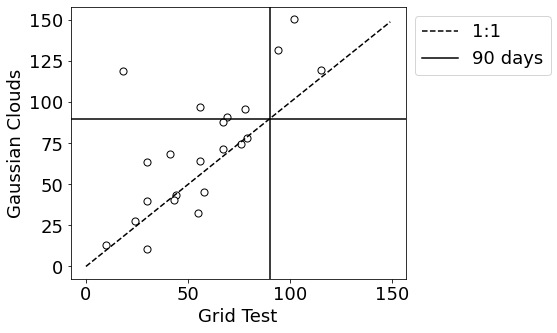

In [23]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

x,y = gridded_coh,outside_eddy_df['CMEMS_avg_coh']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
x_sorted = sorted(x)
fit = [slope*i+intercept for i in x_sorted]
ax.plot(x_sorted,fit)#,label='%s Days (p=%s)'%(num_days,p_val_str),c=color,linestyle='--',zorder=10,linewidth=2)

ax.scatter(x,y,c='white',edgecolor='k',s=50)
ax.plot(range(0,150),range(0,150),c='k',linestyle='--',label='1:1')
ax.axhline(90,c='k',label='90 days')
ax.axvline(90,c='k')

ax.set_xlabel('Grid Test')
ax.set_ylabel('Gaussian Clouds')
plt.legend(bbox_to_anchor=(1,1))

## Paper Figure

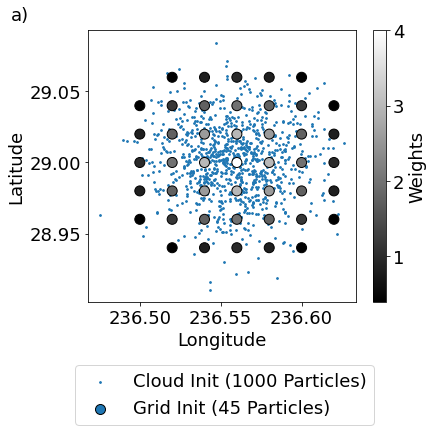

In [24]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.scatter(cloud_ds.lon[:,0],cloud_ds.lat[:,0],s=3,label='Cloud Init (1000 Particles)')

lon,lat = sample_lon[0],sample_lat[0]
lon_i,lat_i = find_nearest(init_lons, lon),find_nearest(init_lats, lat) # target inds
center = (lat_i, lon_i) # center point of the cloud
neighbors = [(center[0] + di, center[1] + dj) for di, dj in offsets] # all of the cloud neighbors
neighbor_ds_locs = np.array([lookup_df.loc[nbr][0] for nbr in neighbors])

ax.scatter([traj_lons[n,0] for n in neighbor_ds_locs],
           [traj_lats[n,0] for n in neighbor_ds_locs],label='Grid Init (%s Particles)'%(len(offsets)),
           c=weights,edgecolor='k',cmap='gray',s=100)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.text(236.42,29.1,'a)')

plt.colorbar(plot,label='Weights')
plt.legend(bbox_to_anchor=(1.1,-0.2))

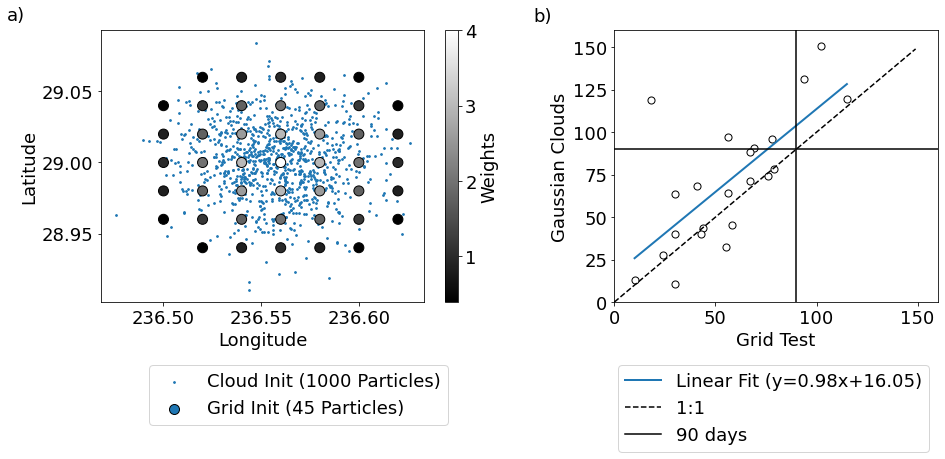

In [35]:
fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [5,4]})
plt.subplots_adjust(wspace=0.3)

####################### PLOT 1 #######################
ax[0].scatter(cloud_ds.lon[:,0],cloud_ds.lat[:,0],s=3,label='Cloud Init (1000 Particles)')

lon,lat = sample_lon[0],sample_lat[0]
lon_i,lat_i = find_nearest(init_lons, lon),find_nearest(init_lats, lat) # target inds
center = (lat_i, lon_i) # center point of the cloud
neighbors = [(center[0] + di, center[1] + dj) for di, dj in offsets] # all of the cloud neighbors
neighbor_ds_locs = np.array([lookup_df.loc[nbr][0] for nbr in neighbors])

ax[0].scatter([traj_lons[n,0] for n in neighbor_ds_locs],
           [traj_lats[n,0] for n in neighbor_ds_locs],label='Grid Init (%s Particles)'%(len(offsets)),
           c=weights,edgecolor='k',cmap='gray',s=100)

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[0].text(236.42,29.1,'a)')

plt.colorbar(plot,label='Weights',ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.1,-0.2))

####################### PLOT 2 #######################
x = np.array(gridded_coh)[~np.isnan(np.array(gridded_coh))]
y = np.array(outside_eddy_df['CMEMS_avg_coh'])[~np.isnan(np.array(gridded_coh))]
slope, intercept, r_value, p_value, std_err = linregress(x,y)
x_sorted = sorted(x)
fit = [slope*i+intercept for i in x_sorted]
ax[1].plot(x_sorted,fit,label='Linear Fit (y=%sx+%s)'%(round(slope,2),round(intercept,2)),c='C0',linewidth=2)

ax[1].scatter(x,y,c='white',edgecolor='k',s=50)
ax[1].plot(range(0,150),range(0,150),c='k',linestyle='--',label='1:1')
ax[1].axhline(90,c='k',label='90 days')
ax[1].axvline(90,c='k')

ax[1].set_xlabel('Grid Test')
ax[1].set_ylabel('Gaussian Clouds')

ax[1].set_xlim([0,160])
ax[1].set_ylim([0,160])

ax[1].text(-40,165,'b)')

ax[1].legend(bbox_to_anchor=(1.,-0.2))

#plt.savefig(data_dir + 'G4_traj_paper_figs/coh_time_gaussian_v_grid.pdf',bbox_inches='tight',pad_inches=0,dpi=350)